In [20]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future-mobintime'
file_prefix = f'week'

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 90

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Provincial Setup with 107 nodes.


In [26]:
filename = 'model_output/2021-02-19/U-r15-t479700-id6-opi-107_90.csv'
filename = 'helvetios-runs/2021-11-17-107_90/week-U-r15-t479700-id6-opt-107_90.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]
mydata = mydata[mydata.index < str(setup.end_date)]
idx = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value').index

In [27]:
baseline = pd.read_csv('helvetios-runs/2021-11-17-107_90/week-U-r15-t1000000-id8-int-107_90-nc.csv', index_col= 'date', parse_dates=True)
baseline = baseline[baseline.index < str(setup.end_date)]

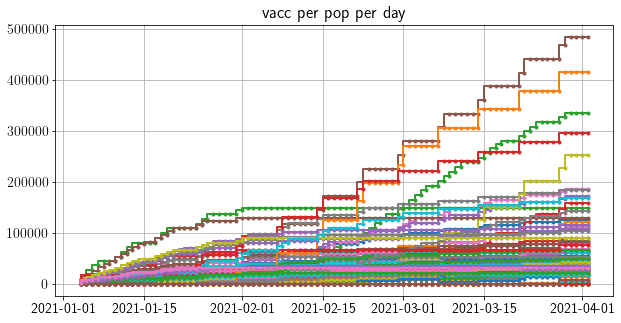

In [28]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(idx, mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum(), lw = 2, ls = '-', marker='.')
#ax.step(idx, stockpile_national, lw = 2, ls = '-', marker='.', c = 'k')

ax.set_title(st + ' per pop per day');
ax.grid()

In [13]:
a = mydata[(mydata['comp'] == 'yell')].pivot(columns = 'place', values=value).sum().sort_values(ascending=False)[0:15].index.unique()
a.sort_values()

Index([], dtype='object', name='place')

In [14]:
mydata = mydata.loc['2021-03-10':]
b = mydata[(mydata['comp'] == 'yell')].pivot(columns = 'place', values=value).sum().sort_values(ascending=False)[0:15].index.unique()
b.sort_values()

In [ ]:
pd.concat([a,b])

In [15]:
list(setup.ind2name)

['Torino',
 'Vercelli',
 'Novara',
 'Cuneo',
 'Asti',
 'Alessandria',
 'Aosta',
 'Imperia',
 'Savona',
 'Genova',
 'La Spezia',
 'Varese',
 'Como',
 'Sondrio',
 'Milano',
 'Bergamo',
 'Brescia',
 'Pavia',
 'Cremona',
 'Mantova',
 'Bolzano',
 'Trento',
 'Verona',
 'Vicenza',
 'Belluno',
 'Treviso',
 'Venezia',
 'Padova',
 'Rovigo',
 'Udine',
 'Gorizia',
 'Trieste',
 'Piacenza',
 'Parma',
 "Reggio nell'Emilia",
 'Modena',
 'Bologna',
 'Ferrara',
 'Ravenna',
 "Forli'-Cesena",
 'Pesaro e Urbino',
 'Ancona',
 'Macerata',
 'Ascoli Piceno',
 'Massa Carrara',
 'Lucca',
 'Pistoia',
 'Firenze',
 'Livorno',
 'Pisa',
 'Arezzo',
 'Siena',
 'Grosseto',
 'Perugia',
 'Terni',
 'Viterbo',
 'Rieti',
 'Roma',
 'Latina',
 'Frosinone',
 'Caserta',
 'Benevento',
 'Napoli',
 'Avellino',
 'Salerno',
 "L'Aquila",
 'Teramo',
 'Pescara',
 'Chieti',
 'Campobasso',
 'Foggia',
 'Bari',
 'Taranto',
 'Brindisi',
 'Lecce',
 'Potenza',
 'Matera',
 'Cosenza',
 'Catanzaro',
 'Reggio di Calabria',
 'Trapani',
 'Palermo',


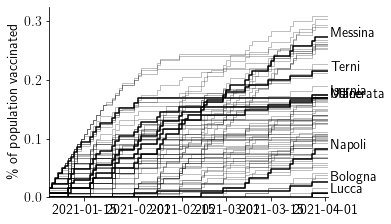

In [29]:
fig, ax = plt.subplots(1,1, figsize = (5,3.5))
i = 8
st = states_names[i]

selected = setup.ind2name
selected = ['Macerata',  'Udine', 'Messina',  'Napoli', "Bologna", "Isernia", "Terni", "Lucca"]

col = sns.color_palette("rocket", 110)
#ax.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)

for i, nd in enumerate(setup.ind2name):
    if nd in selected:
        ax.step(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum().index,
                mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum(), c='k')
        plt.text(setup.end_date, 
                 max(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()),
                 nd, fontsize=14)
    else:
        ax.step(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum().index,
                mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum(), c='k', alpha = .5, lw = .5)
        
        
#ax.set_title(st + ' per pop per day');
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
#ax.legend(loc='upper left', fontsize=14)
#fig.autofmt_xdate()
ax.set_ylim(0)


ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.set_ylabel('Prop. vaccinated', fontsize=14);
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left();
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
ax.set_ylabel('\% of population vaccinated')
fig.savefig('figures/ts_optimal_selected.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

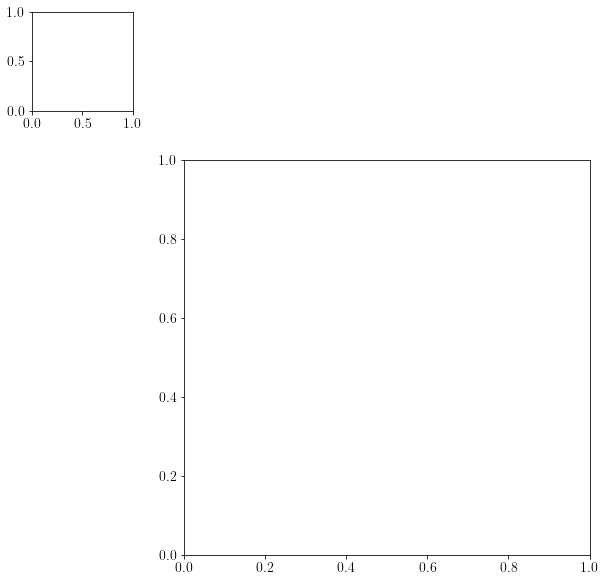

In [30]:
corr_meat = mydata[(mydata['comp'] == 'vacc')].pivot(values = 'value', columns='place').corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_meat,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [18]:
corr_meat.shape

(107, 107)

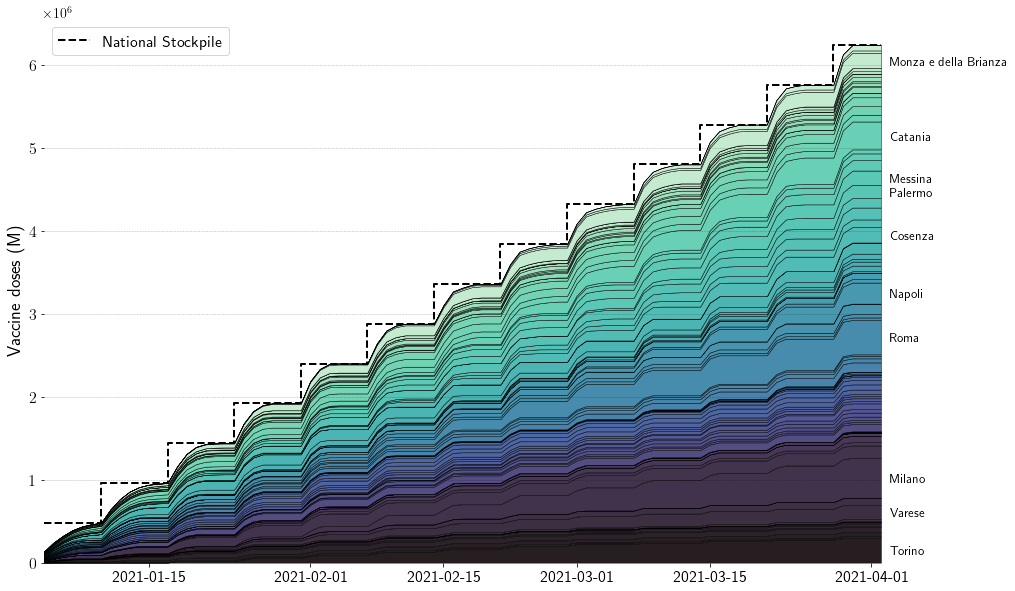

In [31]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
fig.patch.set_facecolor('white')

mpl.rc('text', usetex=True)
mpl.rc('font', size=14)
mpl.rc('legend', fontsize=14)

i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("mako", 110)
#col = sns.color_palette("Paired", 110)
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


#mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum().plot.area(ax = ax, colors=col)# lw = 2, ls = '-', marker='.')
ax.stackplot(idx, [mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum()[pl] for pl in setup.ind2name], 
              edgecolor= 'black', colors = col, lw=.5, ls = '-', alpha = .9)

ax.step(idx, stockpile_national.cumsum(), lw = 2, ls = '--',  c = 'k', label = 'National Stockpile') # marker='.',

acc = 0
for i, ndn in enumerate(setup.ind2name):
    this = mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum()[ndn]
    acc = acc + this
    if this > 1.5e5:
        plt.text(setup.end_date, acc-2*this/4-.05e6, ndn, fontsize=13)

#ax.set_title('Cumulative vaccination per node', );
ax.set_ylabel('Vaccine doses (M)', fontsize=18);
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.legend(loc='upper left', fontsize=16)
#fig.autofmt_xdate()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#ax.grid()
#fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
fig.savefig('figures/ts_optimal_stackplot.pdf')

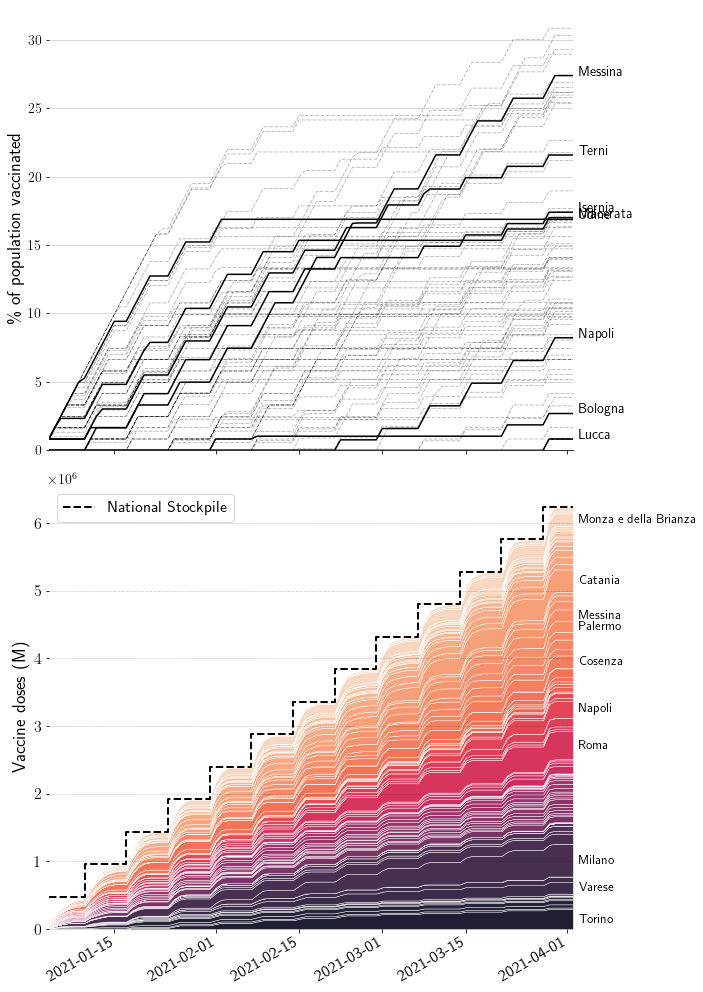

In [32]:
fig, axes = plt.subplots(2,1, figsize = (10,14), sharex=True)
fig.patch.set_facecolor('white')

mpl.rc('text', usetex=True)
mpl.rc('font', size=14)
mpl.rc('legend', fontsize=14)

st = 'vacc'
value = 'value'

ax = axes[0]

### UPPER
selected = setup.ind2name
selected = ['Macerata',  'Udine', 'Messina',  'Napoli', "Bologna", "Isernia", "Terni", "Lucca"]

col = sns.color_palette("rocket", 110)
#ax.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)

for i, nd in enumerate(setup.ind2name):
    if nd in selected:
        ax.plot(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum().index,
                mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()*100, c='k')
        ax.text(setup.end_date, 
                 max(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()*100),
                 nd, fontsize=14)
    else:
        ax.plot(mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum().index,
                mydata[(mydata['comp'] == 'vacc') & (mydata['place'] == nd)]['valuepop'].cumsum()*100, c='k', alpha = .5, ls = '-.', lw = .5)
        
        
#ax.set_title(st + ' per pop per day');
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
#ax.legend(loc='upper left', fontsize=14)
#fig.autofmt_xdate()
ax.set_ylim(0)
ax.grid(True, 'major', 'y', ls='-', lw=.5, c='k', alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.set_ylabel('Prop. vaccinated', fontsize=14);
#ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left();
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
ax.set_ylabel('\% of population vaccinated', fontsize=18)

### LOWER
ax = axes[1]

col = sns.color_palette("rocket", 110)
#col = sns.color_palette("Paired", 110)
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


#mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum().plot.area(ax = ax, colors=col)# lw = 2, ls = '-', marker='.')
ax.stackplot(idx, [mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum()[pl] for pl in setup.ind2name], 
              edgecolor= 'white', colors = col, lw=.5, ls = '-', alpha = .9)

ax.step(idx, stockpile_national.cumsum(), lw = 2, ls = '--',  c = 'k', label = 'National Stockpile') # marker='.',


acc = 0
for i, ndn in enumerate(setup.ind2name):
    this = mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum()[ndn]
    acc = acc + this
    if this > 1.5e5:
        plt.text(setup.end_date, acc-2*this/4-.05e6, ndn, fontsize=13)

#ax.set_title('Cumulative vaccination per node', );
ax.set_ylabel('Vaccine doses (M)', fontsize=18);
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.legend(loc='upper left', fontsize=16)
#
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
#ax.get_yaxis().tick_left()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.autofmt_xdate()
fig.tight_layout()

#ax.grid()
#fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
fig.savefig('figures/ts_both.pdf')

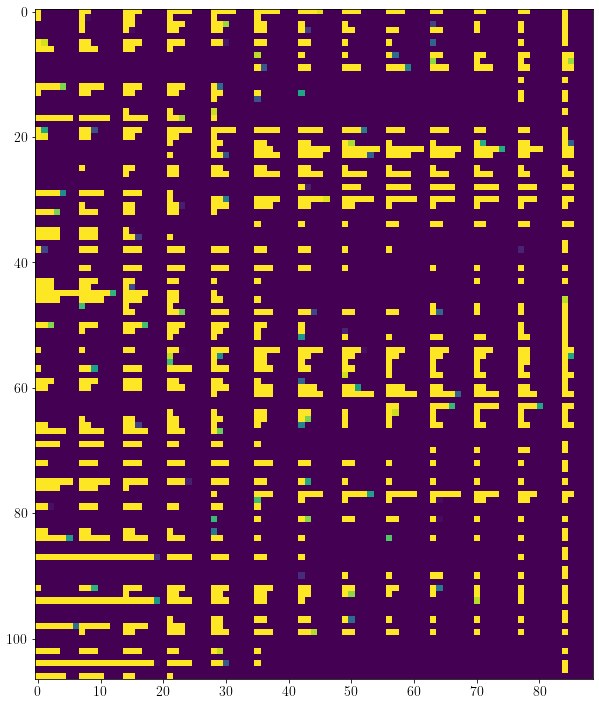

In [52]:
fig, axes = plt.subplots(1,1, figsize = (10,15))
fig.patch.set_facecolor('white')
axes.imshow(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='valuepop').T)

No handles with labels found to put in legend.


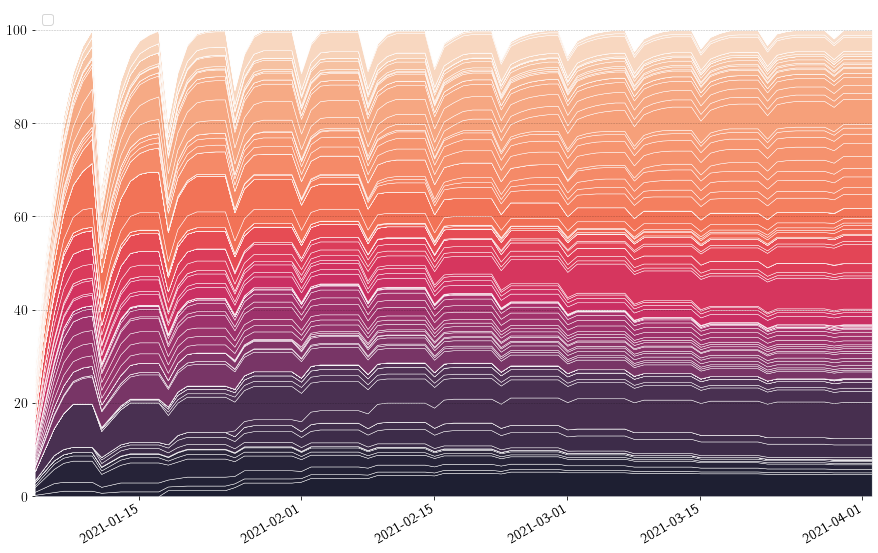

In [33]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
fig.patch.set_facecolor('white')


i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("rocket", 110)
#col = sns.color_palette("Paired", 110)
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


#mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum().plot.area(ax = ax, colors=col)# lw = 2, ls = '-', marker='.')
ax.stackplot(idx, 
             [100*mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value)[pl].to_numpy().cumsum() / 
              #mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1) 
              stockpile_national.cumsum()
              for i, pl in enumerate(setup.ind2name)], 
              edgecolor= 'white', colors = col, lw=.5, ls = '-', alpha = .9)

#ax.step(idx, stockpile_national.cumsum(), lw = 2, ls = '--',  c = 'k', label = 'National Stockpile') # marker='.',


#ax.set_title('Cumulative vaccination per node', );
ax.set_ylabel('% of allocation', fontsize=14);
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.legend(loc='upper left', fontsize=14)
fig.autofmt_xdate()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#ax.grid()
#fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
fig.savefig('figures/ts_optimal_stackplot_2.pdf')

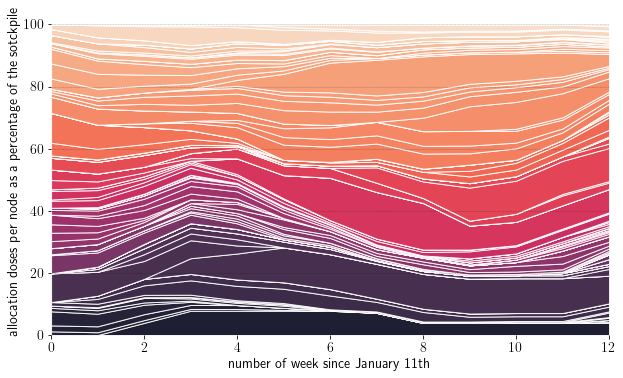

In [35]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
fig.patch.set_facecolor('white')


i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("rocket", 110)
#col = sns.color_palette("Paired", 110)
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


#mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).cumsum().plot.area(ax = ax, colors=col)# lw = 2, ls = '-', marker='.')
ax.stackplot(np.arange(13), 
             [100*mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).resample('W').sum()[pl].to_numpy()/
                  mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).resample('W').sum().sum(axis=1)
              #mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1) 
              #stockpile_national.cumsum()
              for i, pl in enumerate(setup.ind2name)], 
              edgecolor= 'white', colors = col, lw=1, ls = '-', alpha = .9)

#ax.step(idx, stockpile_national.cumsum(), lw = 2, ls = '--',  c = 'k', label = 'National Stockpile') # marker='.',


#ax.set_title('Cumulative vaccination per node', );
ax.set_ylabel('allocation doses per node as a percentage of the sotckpile', fontsize=14);
ax.set_xlabel('number of week since January 11th', fontsize=14);
#ax.grid()
#ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
#ax.legend(loc='upper left', fontsize=14)
#fig.autofmt_xdate()
ax.set_xlim(0,12)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#ax.grid()
#fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
fig.savefig('figures/SI_ts_optimal_stackplot_proportional.pdf')

In [29]:
mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum()[ndn]

20336.803912700227

No handles with labels found to put in legend.


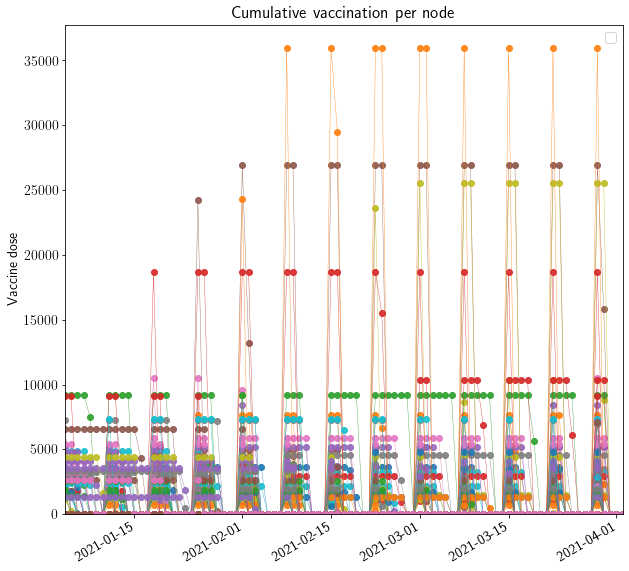

In [36]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("viridis", 110)
ax.plot(idx, mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw=.4, ls = '-', alpha = .9,  marker='o')

ax.set_title('Cumulative vaccination per node');
ax.set_ylabel('Vaccine dose');
#ax.grid()
ax.set_xlim(setup.start_date, setup.end_date-datetime.timedelta(1))
ax.set_ylim(0)
ax.legend()
fig.autofmt_xdate()
fig.savefig('figures/ts_optimal.pdf')

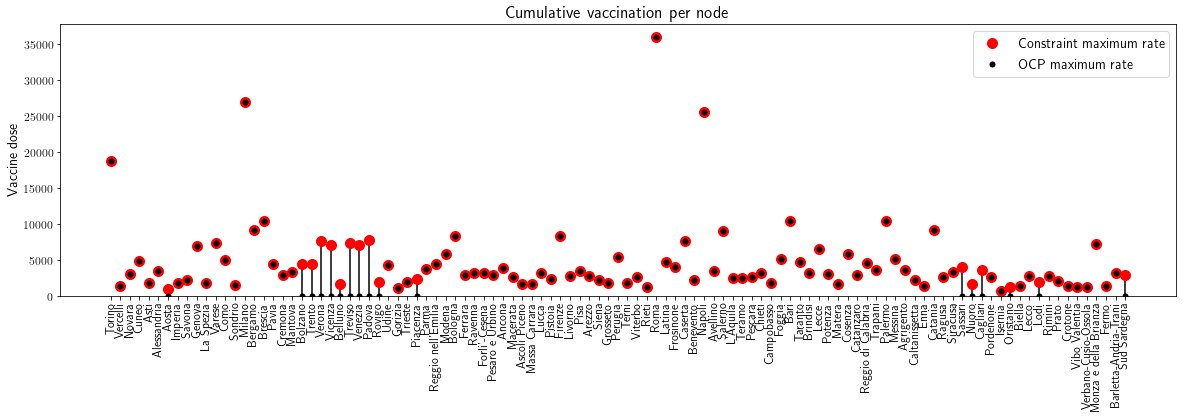

In [19]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'
col = sns.color_palette("viridis", 110)

for i in range(len(setup.ind2name)):
    plt.plot([setup.ind2name[i], setup.ind2name[i]],
             [maxvaccrate_regional.max(axis=1)[i], mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).max()[setup.ind2name[i]]],
             c='k', ls = '-')
    

ax.plot(setup.ind2name, maxvaccrate_regional.max(axis=1), lw=3, ls = '', alpha = 1,  marker='o', c='r', markersize = 10
       , label = 'Constraint maximum rate')
ax.plot(setup.ind2name, [mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).max()[nd] for nd in setup.ind2name], 
        lw=3, ls = '', alpha = 1,  marker='o', c = 'k', markersize = 5, label = 'OCP maximum rate')



ax.set_title('Cumulative vaccination per node');
ax.set_ylabel('Vaccine dose');
#ax.grid()
ax.set_ylim(0)
ax.legend()
plt.xticks(rotation='vertical')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('figures/SI_constraint_dist.pdf')

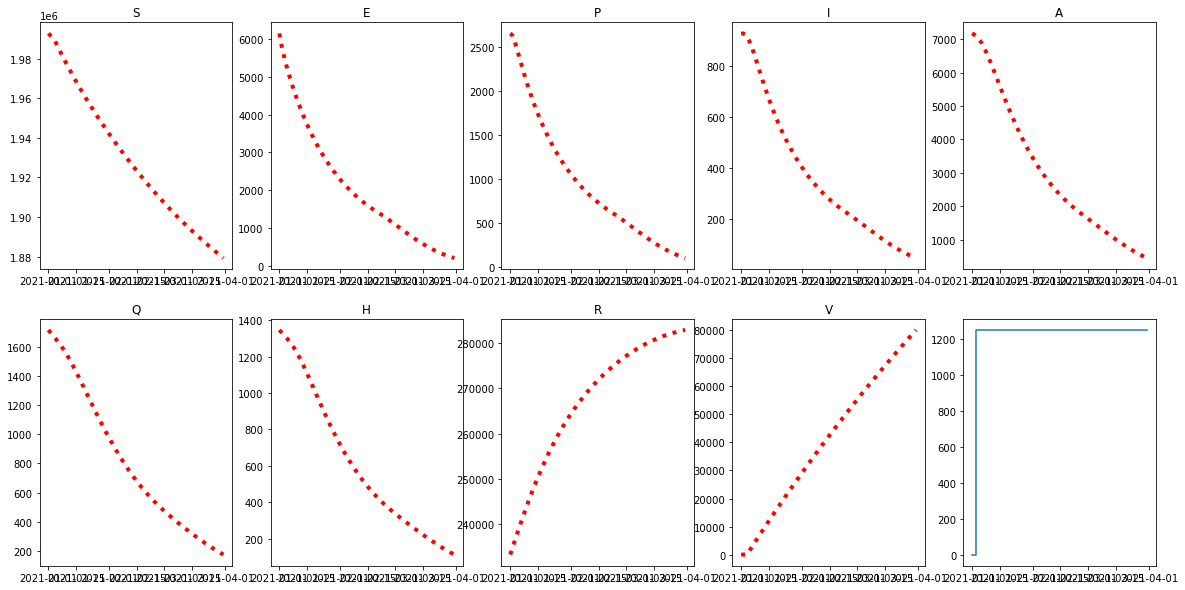

In [6]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0
myopt=None

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

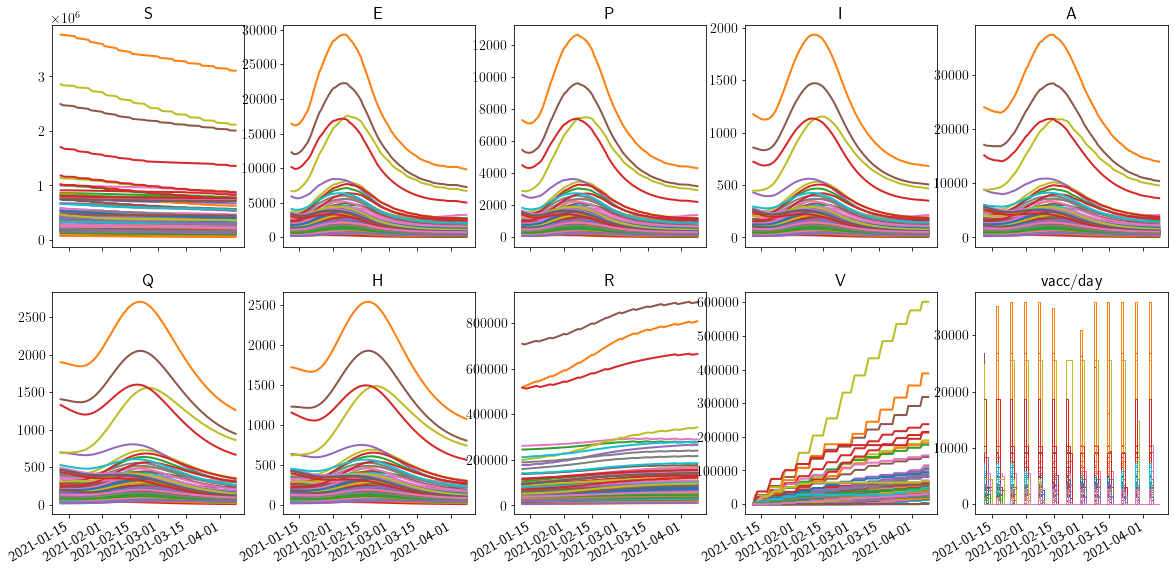

In [22]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()
fig.savefig('figures/SI_all_states.pdf')

ValueError: x and y must have same first dimension, but have shapes (88,) and (89,)

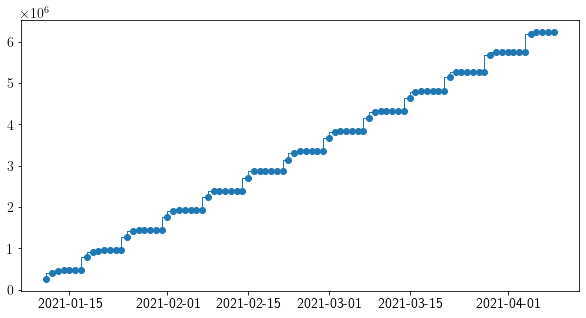

In [20]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1).cumsum(), lw = 1, ls = '-', marker='o')
ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index[:-1],  stockpile_national, lw = 1, ls = '-', marker='o')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()
#ax.set_ylim(0)

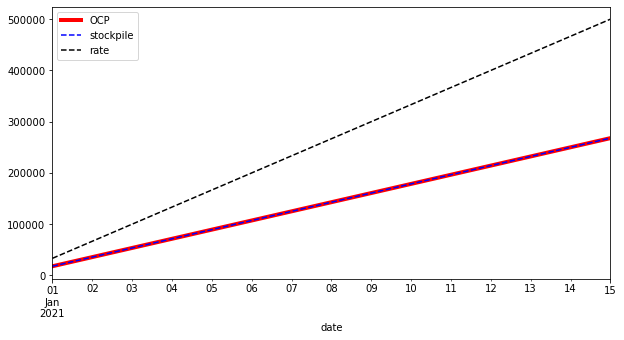

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum().plot(c = 'r', lw = 4, label = 'OCP')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*dosesperweek/7), c='b', ls='--', label='stockpile')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
ax.legend()
#ax.set_ylim(0,1e6)

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()

# All TS analysis

In [4]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetupProvinces import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q','H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [5]:
outdir = '2021-01-19-107_30/'
file_list = glob.glob(outdir + '*.csv')
#outdir = '2021-01-14_nanoechopc/'
#file_list = glob.glob(outdir + 'microechopc*.csv')
file_list = [fn for fn in file_list if 'opt' in fn]
file_list.sort()
print(len(file_list))

25


In [12]:
float(filename.split('-')[-4][1:])*1e6

1000000.0

In [13]:
float(filename.split('-')[-3][1:])

12500.0

In [14]:
filename.split('-')

['2021', '01', '17', '10_30/week', 'U', 'r1', 't12500', 'opt', '10_30.csv']

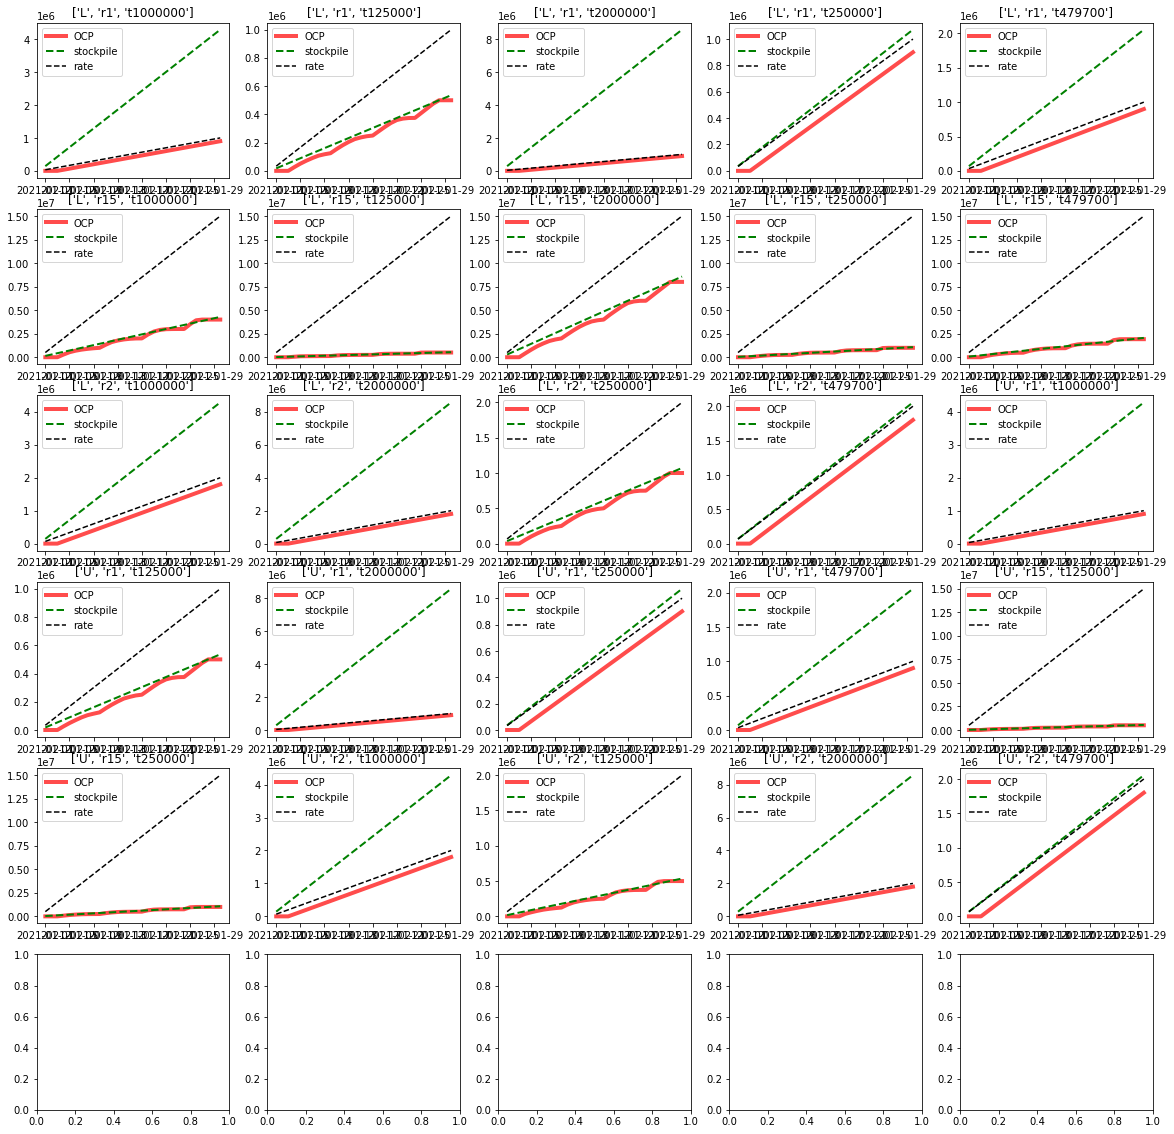

In [7]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum(),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*dosesperweek/7), c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e4)
    ax[i].set_title(filename.split('-')[-5:-2])

In [17]:
for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6/30
    print(dosesperweek, ratepermonth, filename)

12500.0 0.0 2021-01-17-10_30/week-U-r0-t12500-opt-10_30.csv
25000.0 0.0 2021-01-17-10_30/week-U-r0-t25000-opt-10_30.csv
12500.0 33333.333333333336 2021-01-17-10_30/week-U-r1-t12500-opt-10_30.csv
25000.0 33333.333333333336 2021-01-17-10_30/week-U-r1-t25000-opt-10_30.csv


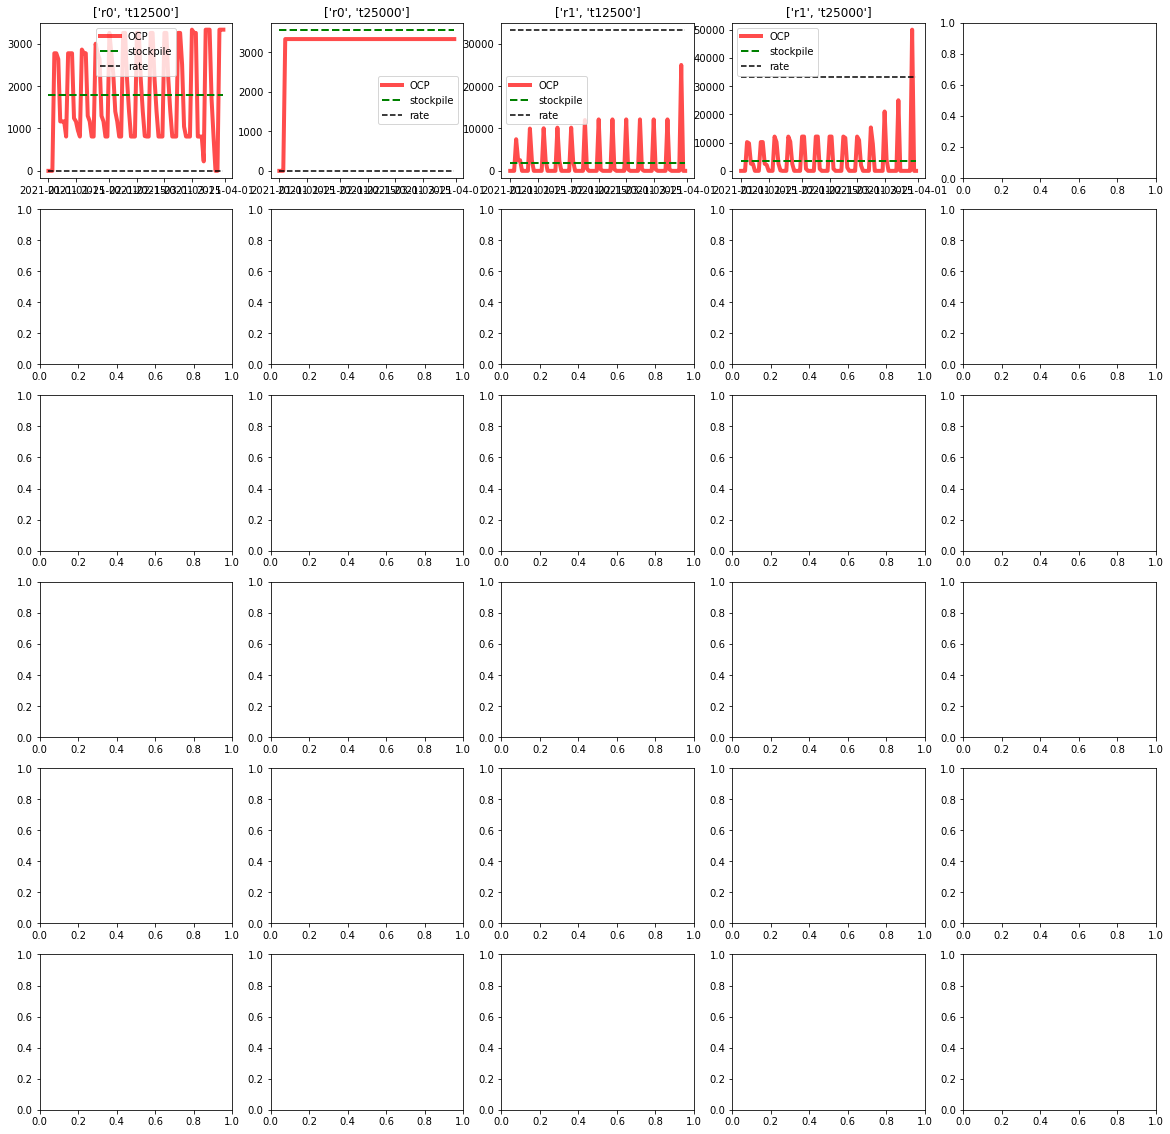

In [22]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*dosesperweek/7, c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*ratepermonth/30, c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e6)
    ax[i].set_title(filename.split('-')[-4:-2])